In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ollama
from tqdm import tqdm

In [2]:
df = pd.read_excel('LK99_Data.xlsx')
df['abstract'][0]


"This paper examines the way of thinking and limitations of physicists regarding the phenomenon of superconductivity and outlines how room-temperature and ambient-pressure superconductors can be developed through the statistical thermodynamic background of the liquid state theory. In hypothesis, the number of electron states should be limited by confining them to a state close to one-Dimension. Simultaneously, the electron-electron interactions should be frequent enough for the electrons to have liquid-like properties. As an example of implementing the hypothesis, our team reports the development of room-temperature and ambient-pressure superconductivity of a material named LK-99 (superconducting compound name developed in the research), whose structure was revealed through numerous experiments with a clue found by chance. Moreover, we summarize the theoretical and experimental basis for the characteristics and discovery of the world's first superconducting material surpassing the crit

In [22]:
init_prompt = 'You are a hypothesis bot. You take a hypothesis along with a short paragraph. You respond with a single word: "yes" means the hypothesis is substantiated in the paragraph, "no" means the hypothesis is not substantiated in the short paragrah, or "neutral" if it cannot be determined whether the hypothesis is substantiated in the paragraph. Do you understand?'
all_lk99_responses = []
hypothesis = 'LK-99 is a room-temperature superconductor.'
for i in tqdm(range(len(df))):
    abs1 = df['abstract'][i]
    test_abstract = f'Hypothesis: "{hypothesis}" Statement: "{abs1}"'
    response = ollama.chat(model='llama3',messages=[{'role':'system','content':init_prompt},{'role':'user','content':test_abstract}])
    all_lk99_responses.append(response['message']['content'].lower().replace('.','').replace(' ',''))
df['lk99_veracity'] = all_lk99_responses

100%|██████████| 60/60 [00:43<00:00,  1.36it/s]


In [4]:
df = df.sort_values(by=['date'])
df.head()

,paper_title,doi,journal,journal_if,citations,date,abstract,lk99_veracity
0,Consideration for the development of room-temp...,10.6111/JKCGCT.2023.33.2.061,Journal of the Korea Crystal Growth and Crysta...,0.3,25,2023-04-18,This paper examines the way of thinking and li...,yes
1,The First Room-Temperature Ambient-Pressure Su...,10.48550/arXiv.2307.12008,arxiv,NaN,64,2023-07-22,"For the first time in the world, we succeeded ...",yes
2,Superconductor Pb10−xCux(PO4)6O showing levita...,10.48550/arXiv.2307.12037,arxiv,NaN,56,2023-07-22,"A material called LK-99, a modified-lead apati...",yes
58,Origin of correlated isolated flat bands in co...,10.48550/arXiv.2307.16892,arxiv,NaN,42,2023-07-31,A recent report of room temperature supercondu...,no
53,Electronic Structure and Vibrational Stability...,10.48550/arXiv.2308.01135,arxiv,NaN,23,2023-08-02,Two recent preprints in the physics archive (a...,yes


In [5]:
import datetime
import numpy as np

#MANIFOLD
betting_data = [[datetime.date(2023,7,26),0.25],
                [datetime.date(2023,7,27),0.20],
                [datetime.date(2023,7,28),0.20],
                [datetime.date(2023,7,29),0.18],
                [datetime.date(2023,7,30),0.15],
                [datetime.date(2023,7,31),0.30],
                [datetime.date(2023,8,1),0.60],
                [datetime.date(2023,8,2),0.39],
                [datetime.date(2023,8,3),0.34],
                [datetime.date(2023,8,4),0.37],
                [datetime.date(2023,8,5),0.35],
                [datetime.date(2023,8,6),0.40],
                [datetime.date(2023,8,7),0.37],
                [datetime.date(2023,8,8),0.17],
                [datetime.date(2023,8,9),0.16],
                [datetime.date(2023,8,10),0.16],
                [datetime.date(2023,8,11),0.13],
                [datetime.date(2023,8,12),0.13],
                [datetime.date(2023,8,13),0.12],
                [datetime.date(2023,8,14),0.12],
                [datetime.date(2023,8,15),0.11],
                [datetime.date(2023,8,16),0.10],
                [datetime.date(2023,8,31),0.08],
                [datetime.date(2023,9,30),0.06],
                [datetime.date(2023,10,31),0.04]]
betting_df = pd.DataFrame(np.array(betting_data),columns=['date','probability'])

In [24]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import norm
means_list = [0]
means_list = [0]
variances_list = [100]
cdf_list = [0.5]

for i, row in df.iterrows():
    #Add means
    if row['lk99_veracity']=='yes':
        mean=1
    elif row['lk99_veracity']=='neutral':
        mean=0
    elif row['lk99_veracity']=='no':
        mean=-1
    #Add stdevs
    if type(row['journal_if']) is not float:
        variance=100
    else:
        if float(row['journal_if'])<1:#Not a trusted journal
            variance=80
        if float(row['journal_if'])<5:#Semi-trusted journal
            variance=20
        else:#Well-respected journal
            variance=10
    new_variance = 1./(1./variances_list[-1] + 1./variance)
    new_mean = new_variance * (means_list[-1]/variances_list[-1] + mean/variance)
    #print(row['lk99_veracity'],row['journal_if'],new_mean,new_variance)
    means_list.append(new_mean)
    variances_list.append(new_variance)
    cdf_list.append(1.0-norm.cdf(0,new_mean,new_variance))

df['means']=means_list[1:]
df['iter_variances']=variances_list[1:]
df['likelihood']=cdf_list[1:]

#all_dates = [df['date'][0]]+df['date'].tolist()
#plt.plot(all_dates,means_list)

#fig = go.Figure(data=[go.Scatter(x=all_dates,y=means_list,mode='lines+markers')])
#fig.show()
import plotly.express as px
fig = px.line(df,x='date',y='likelihood',hover_name='paper_title',hover_data=['doi','lk99_veracity','journal','journal_if','citations'],markers=True)
#fig.add_scatter(x=betting_df['date'],y=betting_df['probability'])
fig.update_layout(title={'text':'Is LK-99 a Room-Temperature Superconductor?','font':{'size':30}})
fig.show()

/home/meschw04/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [38]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import norm
means_list = [0]
means_list = [-100]
means_list = [-90]
variances_list = [100]
cdf_list = [0.5]

for i, row in df.iterrows():
    #Add means
    if row['lk99_veracity']=='yes':
        mean=1
    elif row['lk99_veracity']=='neutral':
        mean=0
    elif row['lk99_veracity']=='no':
        mean=-1
    #Add stdevs
    if type(row['journal_if']) is not float:
        variance=100
    else:
        if float(row['journal_if'])<1:#Not a trusted journal
            variance=80
        if float(row['journal_if'])<5:#Semi-trusted journal
            variance=20
        else:#Well-respected journal
            variance=10
    new_variance = 1./(1./variances_list[-1] + 1./variance)
    new_mean = new_variance * (means_list[-1]/variances_list[-1] + mean/variance)
    #print(row['lk99_veracity'],row['journal_if'],new_mean,new_variance)
    means_list.append(new_mean)
    variances_list.append(new_variance)
    cdf_list.append(1.0-norm.cdf(0,new_mean,new_variance))

df['means']=means_list[1:]
df['iter_variances']=variances_list[1:]
df['likelihood_adjusted']=cdf_list[1:]

#all_dates = [df['date'][0]]+df['date'].tolist()
#plt.plot(all_dates,means_list)

#fig = go.Figure(data=[go.Scatter(x=all_dates,y=means_list,mode='lines+markers')])
#fig.show()
import plotly.express as px
fig = px.line(df,x='date',y='likelihood_adjusted',hover_name='paper_title',hover_data=['doi','lk99_veracity','journal','journal_if','citations'],markers=True)
fig.add_scatter(x=betting_df['date'],y=betting_df['probability'])
fig.update_layout(title={'text':'Is LK-99 a Room-Temperature Superconductor?','font':{'size':30}})
fig.show()

/home/meschw04/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



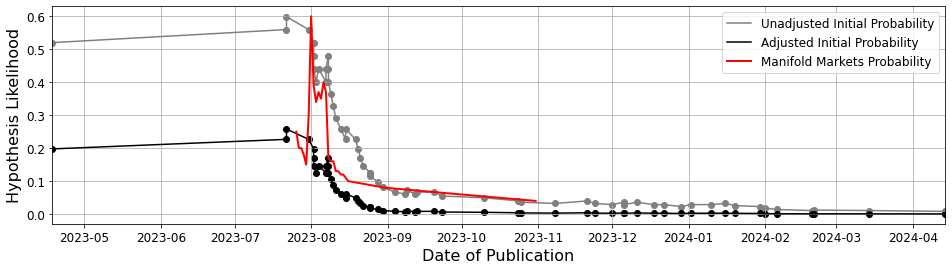

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(df['date'],df['likelihood'],color='gray',label='Unadjusted Initial Probability')
plt.scatter(df['date'],df['likelihood'],color='gray')
plt.plot(df['date'],df['likelihood_adjusted'],color='k',label='Adjusted Initial Probability')
plt.scatter(df['date'],df['likelihood_adjusted'],color='k')
plt.plot(betting_df['date'],betting_df['probability'],color='r',linewidth=2,label='Manifold Markets Probability')
plt.xlabel('Date of Publication',fontsize=16)
plt.ylabel('Hypothesis Likelihood',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([df['date'].tolist()[0],df['date'].tolist()[-1]])
plt.legend(fontsize=12)
plt.grid()
plt.show()